In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb

!pip install -q shap
import shap

from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance

In [2]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [3]:
corDefault = "#6688AA"
corViridis = ['#440154', '#414487', '#2a788e', '#22a884', '#7ad151']

def set_plot_style():
    # Background colors
    plt.figure().patch.set_facecolor("0.85")
    plt.axes().set(facecolor="0.85")
    
    # Hiding grid
    plt.grid(False)
    
    # Setting only left and bottom spines as visible
    ax = plt.gca()
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Spines color
    ax.spines['bottom'].set_color("black")
    ax.spines['left'].set_color("black")
    
    # Plot size
    plt.gcf().set_size_inches(6, 5)

    # Plot Style
    plt.style.use('seaborn-v0_8-colorblind')

In [4]:
def PlotLineHue(x, y, hue, title, sx, sy, save):
    set_plot_style()
               
    sns.lineplot(x = x, y = y, hue = hue)

    plt.title(title)
                    
    plt.gcf().set_size_inches(sx, sy)

    if (save != ""):
        plt.tight_layout()
        plt.savefig(save)
                    
    plt.show()
    plt.close()

In [5]:
import statsmodels.api as sm


def PlotScatterHue(df, x, y, hue, rolling_mean, title, sx, sy, save):
    set_plot_style()

    lowess = sm.nonparametric.lowess
    smoothed = lowess(y.fillna(0), x, frac=0.1)
    
    sns.scatterplot(x = x, y = y, hue = hue)
    #plt.plot(x, rolling_mean, color = 'black')
    #plt.plot(x, smoothed[:, 1], color='black', label='LOWESS')
    sns.lmplot(x = x, y = y, data = df, ci = None)

    plt.title(title)
                    
    plt.gcf().set_size_inches(sx, sy)

    if (save != ""):
        plt.tight_layout()
        plt.savefig(save)
                    
    plt.show()
    plt.close()

# **DATASET LOADING**

In [7]:
df = pd.read_csv("../data/processed/01_Data_Cleaning.csv")
df['date'] = pd.to_datetime(df['date'])

df.head()

,date,sell_quantity,sell_value,buy_quantity,buy_value,daily_balance,inventory,avg_temperature,precipitation,incc,fuel_price,is_holiday
0,2024-01-01,0.0,NaN,0.0,NaN,0,175,24.9,0.1,0.0027,6.04,1
1,2024-01-02,163.0,32.10,280.0,28.97,117,292,25.0,0.2,0.0027,6.04,0
2,2024-01-03,215.0,31.13,0.0,28.97,-215,77,24.8,4.9,0.0027,6.04,0
3,2024-01-04,0.0,NaN,240.0,28.43,240,317,24.8,0.0,0.0027,6.04,0
4,2024-01-05,55.0,35.50,240.0,28.43,185,502,25.1,0.0,0.0027,6.04,0


# **FEATURE ENGINEERING**

## **DEMAND, SUPPLY AND STOCK DYNAMICS**

Binary flag indicating whether no units were sold on a given day.

In [11]:
df['no_sales'] = (df['sell_quantity'] == 0).astype(int)

<br>
Gross margin per unit (selling price / buying price) to measure profitability. It will be the primary target variable for profit optimization.

In [13]:
df['price_margin'] = df.apply(lambda row: (row['sell_value'] / row['buy_value']) if row['sell_value'] != 0 else np.nan, axis = 1)

3-day rolling average of the daily selling and buying prices, used to smooth out short-term fluctuations and highlight trends.  
The 3-day standard deviation captures short-term volatility in selling prices.

In [15]:
df['rolling_mean_sell_value'] = df['sell_value'].rolling(window = 3, min_periods = 1).mean()
df['rolling_mean_buy_value'] = df['buy_value'].rolling(window = 3, min_periods = 1).mean()

df['rolling_std_sell_value'] = df['sell_value'].rolling(window = 3).std()

<br>
Lag features of daily quantity sold (1-day and 7-day), allowing the model to detect temporal patterns or autocorrelation in demand. As well as, previous day’s inventory value, to help understand dynamic stock variation, and 7-day rolling average of inventory, reflecting smoothed stock availability.

In [17]:
df['sell_quantity_lag_1'] = df['sell_quantity'].shift(1)
df['sell_quantity_lag_7'] = df['sell_quantity'].shift(7)

df['inventory_lag_1'] = df['inventory'].shift(1)
df['avg_inventory_rolling'] = df['inventory'].rolling(window = 7).mean()

<br>
To measure how quickly inventory is being sold relative to the previous day's stock level.

In [19]:
df['inventory_turnover'] = df['sell_quantity'] / (df['inventory_lag_1'] + 1e-6)

<br>
7-day average of quantity sold.

In [21]:
df['avg_sell_quantity_last_7d'] = df['sell_quantity'].rolling(window = 7).mean()

<br>
Daily percentage change in selling and buying prices, indicating price volatility.

In [23]:
df['sell_value_pct_change'] = df['sell_value'].pct_change().replace([np.inf, -np.inf], np.nan)
df['buy_value_pct_change'] = df['buy_value'].pct_change().replace([np.inf, -np.inf], np.nan)

## **EXOGENOUS VARIABLES: WEATHER, HOLIDAYS AND FUEL PRICE**

Flags for moderate (2.5–10 mm) and heavy (≥10 mm) daily rainfall, based on Brazilian climate thresholds, which may affect sales of construction materials like cement.

In [26]:
df['is_moderate_rain'] = (df['precipitation'] >= 2.5) & (df['precipitation'] < 10)
df['is_heavy_rain'] = df['precipitation'] >= 10

In [27]:
df['precip_bin'] = pd.cut(
    df['precipitation'],
    bins = [-float('inf'), 0.1, 2.5, 10, 50, float('inf')],
    labels = ['no rain', 'light', 'moderate', 'heavy', 'torrential']
)

<br>
Temperature bins that categorize daily average temperature into three ranges based on cement curing guidelines:

- **low**: below 10 °C. May slow down or impair proper curing; 
- **optimal**: between 10 °C and 25 °C. Ideal range for cement setting and strength development;
- **high**: above 25 °C. May accelerate drying and reduce surface quality.

In [29]:
df['temperature_bin'] = pd.cut(
    df['avg_temperature'],
    bins = [-float('inf'), 10, 25, float('inf')],
    labels = ['low', 'optimal', 'high']
)

<br>
Date-based time features that help the model capture seasonal patterns in demand and pricing.

In [31]:
df['month'] = df['date'].dt.month
df['is_weekend'] = df['date'].dt.dayofweek
df['is_weekend'] = df['is_weekend'].apply(lambda x: True if x > 4 else False)
df['quarter'] = df['date'].dt.quarter

<br>
Incorporate anticipation effect.

In [33]:
k = 1
df.loc[0, 'days_until_holiday'] = 0

for i in range(1, len(df)):
    if (df.loc[i, 'is_holiday'] == 1):
        h = df.loc[i, 'date']

        for j in range(k, i):
            df.loc[j, 'days_until_holiday'] = abs((h - df.loc[j, 'date']).days)

        k = i + 1

df['days_until_holiday'] = df['days_until_holiday'].fillna(0)

<br>Lag features of fuel prices that allow the model to detect delayed effects of transportation cost fluctuations on cement pricing.

In [35]:
df['fuel_price_lag_30'] = df['fuel_price'].shift(30)
df['fuel_price_lag_60'] = df['fuel_price'].shift(60)

<br>3-day rolling average of fuel prices that helps the model capture short-term cost trends.

In [37]:
df['rolling_mean_fuel_price'] = df['fuel_price'].rolling(window = 3, min_periods = 1).mean()

<br>
Daily percentage change in fuel prices, indicating price volatility.

In [39]:
df['fuel_price_pct_change'] = df['fuel_price'].pct_change().replace([np.inf, -np.inf], np.nan).fillna(0)

<br>

The `fuel_price_vs_buy_value` feature represents the difference between the daily percentage change in diesel prices and the daily percentage change in product purchase cost (`buy_value`).
- A positive value means fuel prices increased more than material cost, indicating rising logistical pressure;  
- A negative value means material cost increased more than fuel, suggesting upstream price pressure unrelated to logistics;  
- A value close to zero indicates that fuel and material costs are moving in sync, with no dominant inflation driver.

In [41]:
df['fuel_price_vs_buy_value'] = df['fuel_price_pct_change'] - df['buy_value_pct_change']

## **INFLATION-AJUSTED FEATURES**

Lagged values of monthly INCC inflation rate, allowing the model to capture inflation trends and their delayed effects on pricing.

In [44]:
df['incc_lag_month'] = df['incc'].shift(30)
df['incc_lag_2_month'] = df['incc'].shift(60)

<br>
Month-over-month change in the INCC inflation rate.

In [46]:
df['incc_monthly_change'] = df['incc'] - df['incc'].shift(30)

<br>

The `sell_value_pct_vs_incc` feature represents the difference between the daily percentage change in selling price and the INCC inflation rate.
  - A positive value means the selling price increased more than inflation on that day, indicating a potential real price gain;
  - A negative value means the price increased less than inflation, or even decreased, indicating a real loss in value;
  - A value close to zero means the price kept pace with inflation, a neutral adjustment.

In [48]:
df['sell_value_pct_vs_incc'] = df['sell_value_pct_change'] - df['incc']

# **EXPLORATORY DATA ANALYSIS**

## **SELL_QUANTITY**

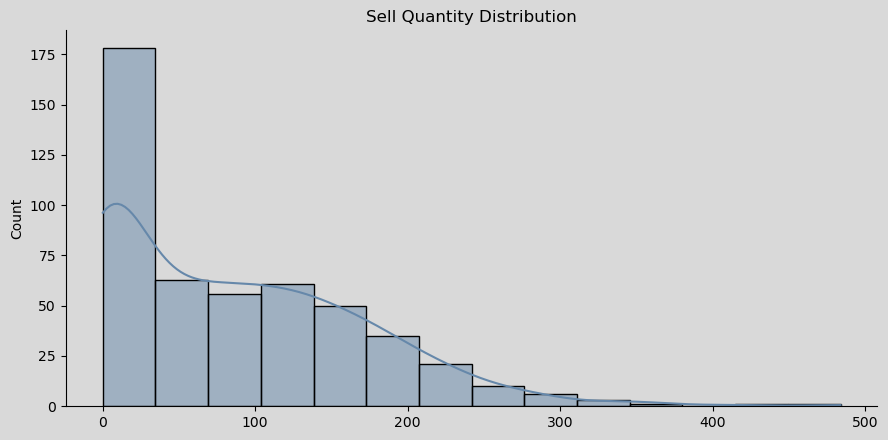

In [51]:
set_plot_style()

sns.histplot(df['sell_quantity'].dropna(), kde = True, color = corDefault)
plt.title('Sell Quantity Distribution')
plt.xlabel("")
                    
plt.gcf().set_size_inches(9, 4.5)

plt.tight_layout()
plt.savefig("../visuals/11.SellQuantityDistribution.svg")
                    
plt.show()
plt.close()

The target variable `sell_quantity` has a highly right-skewed distribution, with many days showing low or zero sales and a long tail with high outliers.

To address this, we'll apply a log transformation to reduce the impact of extreme values, compressing the long tail, and to help stabilize variance, making relationships with other features more linear.

In [53]:
df['sell_quantity_log'] = np.log1p(df['sell_quantity'])

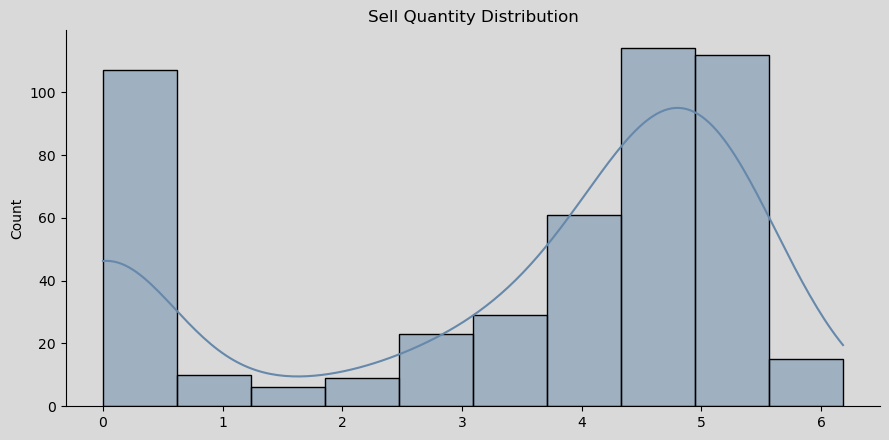

In [54]:
set_plot_style()

sns.histplot(df['sell_quantity_log'].dropna(), kde = True, color = corDefault)
plt.title('Sell Quantity Distribution')
plt.xlabel("")
                    
plt.gcf().set_size_inches(9, 4.5)

plt.tight_layout()
plt.savefig("../visuals/12.SellQuantityDistribution_Log.svg")
                    
plt.show()
plt.close()

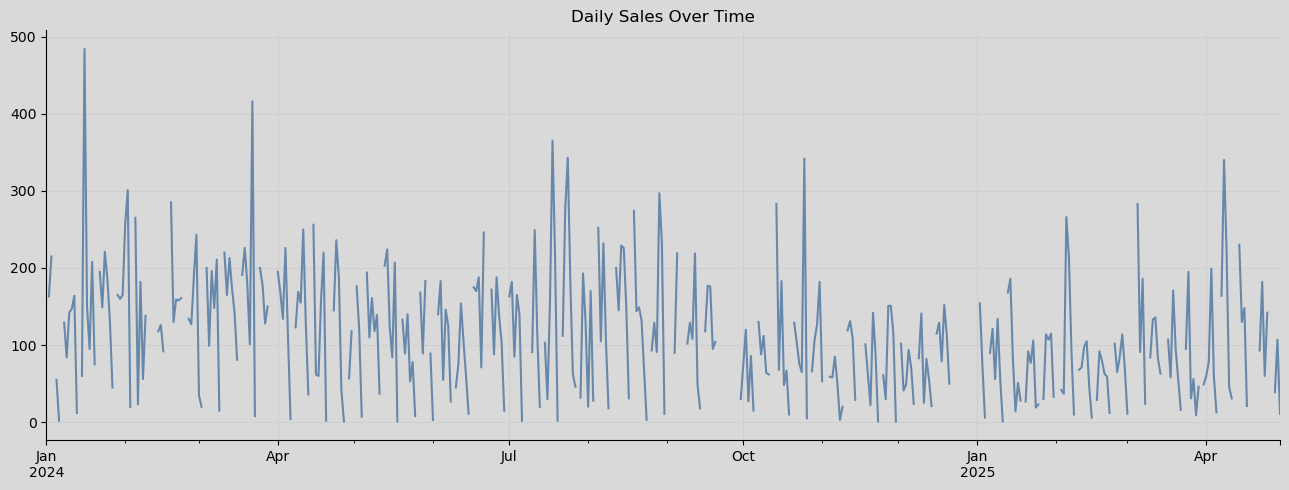

In [55]:
set_plot_style()
df.set_index('date')['sell_quantity'].replace(0, np.nan).plot(color = corDefault)
plt.title('Daily Sales Over Time')

plt.grid(visible = True, color = '0.81')
plt.xlabel("")
plt.gcf().set_size_inches(13, 5)

plt.tight_layout()
plt.savefig("../visuals/13.DailySalesOverTime.svg")

plt.show()
plt.close()

We can see a sustained drop in daily sales volume starting in October 2024, followed by signs of recovery in Q2 2025, that suggests unstable demand behavior.

To respond to these fluctuations and protect profit margins, it's essential to implement a **data-driven dynamic pricing strategy** based on internal variables (cost, sales history, inventory) and external ones (weather, inflation, fuel price, holidays).

The goal of the model is to adjust prices responsively to demand shifts and maximize profit, even during periods of lower sales.

## **SELL_VALUE AND DERIVED FEATURES**

In [58]:
cols = [
    'sell_value',
    'rolling_mean_sell_value',
    'rolling_std_sell_value',
    'sell_value_pct_change',
    'sell_value_pct_vs_incc',
    'sell_quantity_lag_1',
    'sell_quantity_lag_7',
    'avg_sell_quantity_last_7d'
]

cols_desc =[
    'Sell Value',
    'Rolling Mean Sell Value',
    'Rolling Std Sell Value',
    'Sell Value % Change',
    'Sell Value % Change vs INCC',
    '1-Day Lag of Sell Quantity',
    '7-Day Lag of Sell Quantity',
    '1-Week Average Quantity Sold'
]

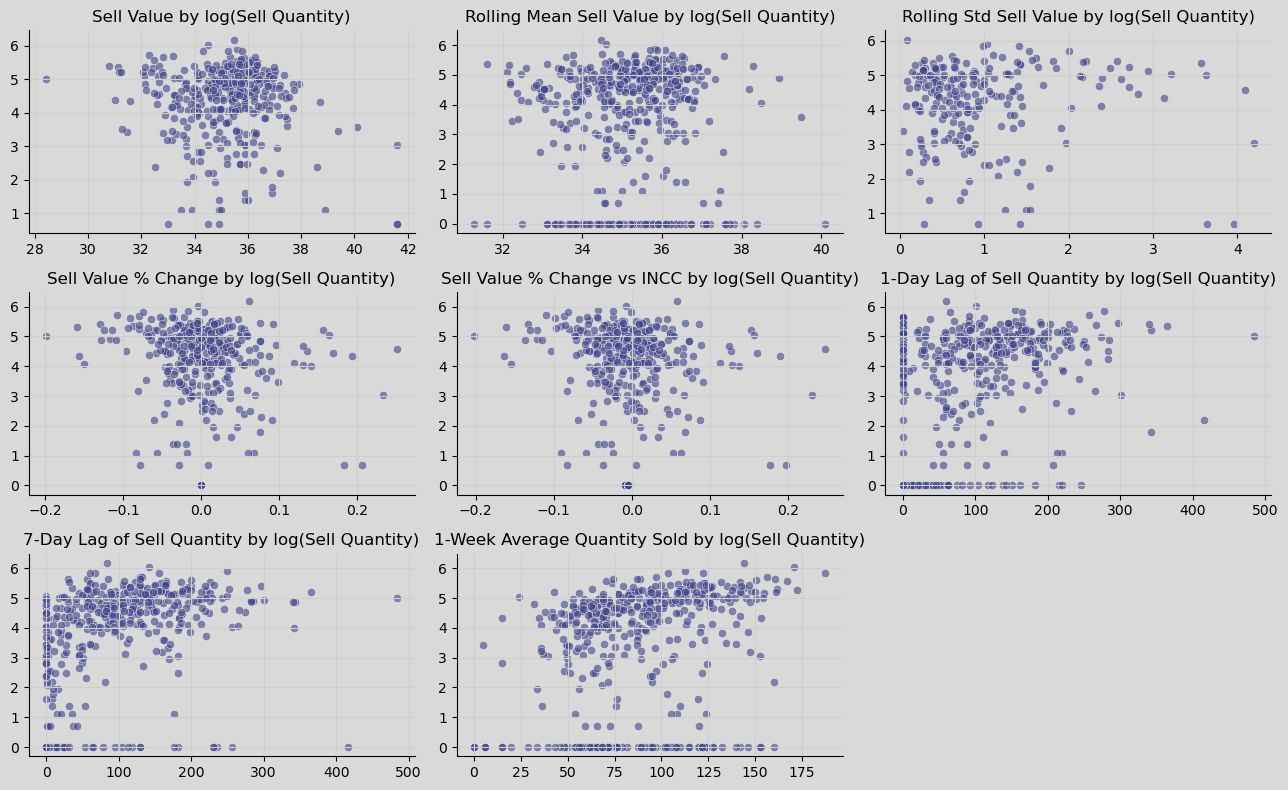

In [59]:
fig, axs = plt.subplots(3, 3, figsize = (13, 8))
fig.patch.set_facecolor("0.85")

c = 0
for i in range(3):
    for j in range(3):
        if ((i == 2) & (j == 2)):
            axs[i,j].axis('off')
        else:
            axs[i,j].grid(visible = True, color = '0.81')
            sns.scatterplot(data = df, x = cols[c], y = 'sell_quantity_log', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
            axs[i,j].set_title(cols_desc[c] + ' by log(Sell Quantity)')
            axs[i,j].set_ylabel("")
            axs[i,j].set_xlabel("")
            axs[i,j].spines.right.set_visible(False)
            axs[i,j].spines.top.set_visible(False)
            axs[i,j].set_facecolor("0.85")
            c += 1

plt.tight_layout()
plt.savefig("../visuals/14.SellValueAndDerivedFeaturesByLogSellQuantity.svg")
plt.show()
plt.close()

We plotted the sale prices against the log of the quantity sold (`sell_quantity_log`) and its derived features.

We can observe:
- `sell_value` and `rolling_mean_sell_value`: these two plots are nearly identical, with data heavily concentrated between 34.00 and 36.00 BRL. There's no clear pattern of declining sales as prices increase (indicating weak elasticity). Because they appear visually redundant, we suspect collinearity. To confirm, we’ll analyze their correlation.
- `rolling_std_sell_value`: this feature shows good dispersion. Some data points with higher price variability seem to align with lower sales. This may suggest that price volatility affects purchase decisions. It's important to keep this feature.
- `sell_value_pct_change` and `sell_value_pct_vs_incc`: most points are near zero, indicating that prices change very little. However, when the price increases more than 0.1, sales tend to drop. Since both features have nearly identical plots, we must assess their redundancy;
- `sell_quantity_lag_1`: shows a moderate positive relationship. When sales were high on the previous day, they tend to remain high on the current day. Indicates short-term demand persistence and can help the model capture momentum;
- `sell_quantity_lag_7`: still displays a visible positive pattern capturing potential weekly cycles or repeated purchase behavior from recurring customers;
- `avg_sell_quantity_last_7d`: shows that a higher 7-day average sales tend to correspond with higher current sales. 

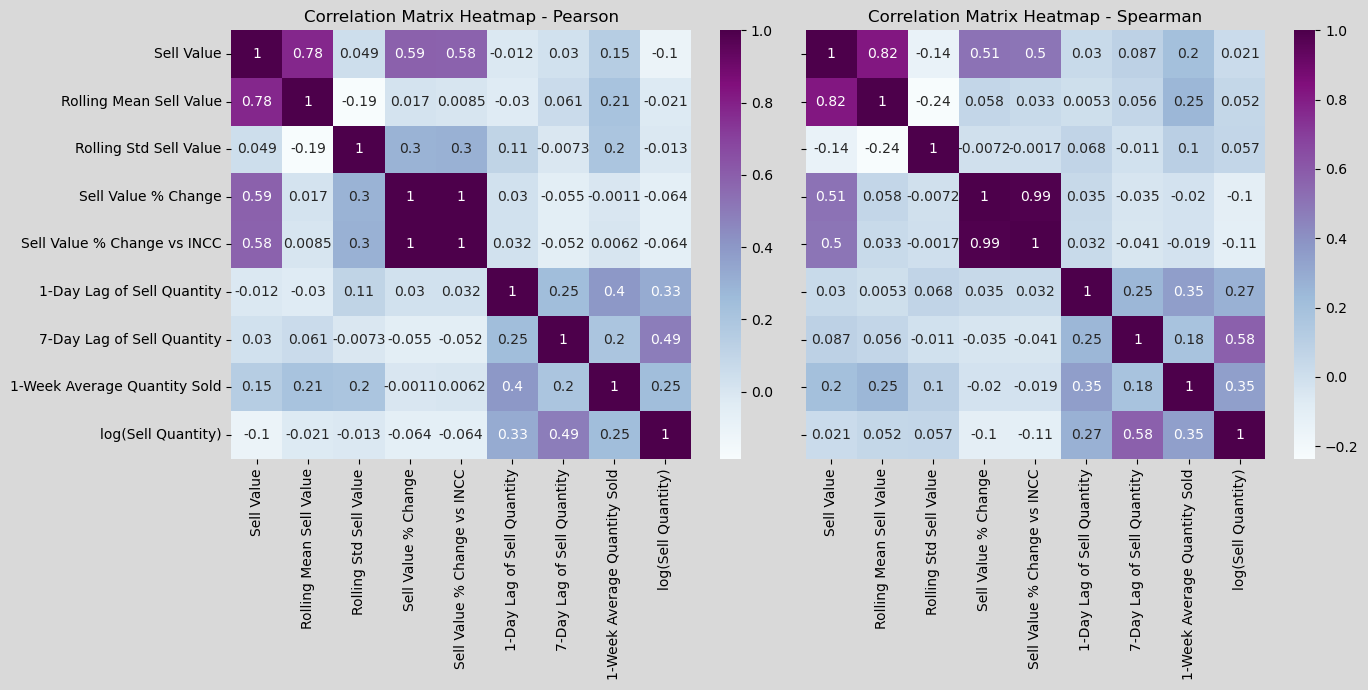

In [61]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (14, 7))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman")

plt.tight_layout()
plt.savefig("../visuals/15.SellValueAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

Key Findings:
- `sell_value` and `rolling_mean_sell_value` showed very high correlation with each other, confirming collinearity and redundancy. Both also have weak correlation with the target variable (`sell_quantity_log`), suggesting low predictive power.
- `sell_value` is also highly correlated with both `sell_value_pct_change` and `sell_value_pct_vs_incc`. Feature importance analysis is necessary to evaluate which feature should be kept.
- `rolling_std_sell_value` shows low correlation with the target, but it may capture price volatility that affects purchasing behavior. It will be evaluated through feature importance.
- `sell_value_pct_change` and `sell_value_pct_vs_incc` have a correlation of 1, confirming total redundancy;
- `sell_quantity_lag_1`: shows strong correlation with the target variable. However, it is also moderately correlated with the other two features, suggesting potential redundancy;
- `sell_quantity_lag_7`: surprisingly, this feature has the highest correlation with the target, indicating a possible weekly demand pattern;
- `avg_sell_quantity_last_7d`: has the weakest correlation with the target.


To validate these conclusions, we'll:
- Train a model using only the selected features and retrieve the built-in `feature_importances_` score to measure each feature’s contribution based on tree splits;
- Use SHAP (SHapley Additive exPlanations) to evaluate the average contribution of each feature across all predictions;
- Apply permutation importance on the test set to measure how much shuffling each feature impacted the model's performance.

In [63]:
corr_df.columns = cols + ['sell_quantity_log']

x_train, x_test, y_train, y_test = train_test_split(corr_df.drop('sell_quantity_log', axis = 1),
                                                    corr_df['sell_quantity_log'],
                                                    test_size = 0.30,
                                                    random_state = 13)

model = xgb.XGBRegressor()
model.fit(x_train, y_train)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_train)

result = permutation_importance(model, x_test, y_test, n_repeats = 10)

xgb_importance = pd.Series(model.feature_importances_, index = x_train.columns, name = "XGB Importance")
shap_importance = pd.Series(np.abs(shap_values).mean(axis = 0), index = x_train.columns, name = "SHAP Importance")
perm_importance = pd.Series(result.importances_mean, index = x_train.columns, name = "Permutation Importance")

importances_df = pd.concat([xgb_importance, shap_importance, perm_importance], axis = 1)
importances_df = importances_df.sort_values("SHAP Importance", ascending = False)
importances_df

,XGB Importance,SHAP Importance,Permutation Importance
sell_value,0.691147,1.607052,1.530286
sell_quantity_lag_7,0.103655,0.329042,0.162975
avg_sell_quantity_last_7d,0.046868,0.181457,0.058425
rolling_std_sell_value,0.043265,0.147819,0.052827
sell_value_pct_change,0.049549,0.073981,0.000312
rolling_mean_sell_value,0.012578,0.062188,0.018098
sell_quantity_lag_1,0.031590,0.055853,0.009217
sell_value_pct_vs_incc,0.021348,0.050226,0.001576


Based on this results:
- `sell_value`: Retained. Despite initial EDA suggesting low correlation, it showed strong importance across all three metrics, making it essential for the model;
- `sell_quantity_lag_7`: Retained. This feature has a high correlation with the target variable and, although its metrics is not as strong as `sell_value`, it shows potential to help the model;
- `avg_sell_quantity_last_7d` and `rolling_std_sell_value`: Tentatively retained. All metrics were low but not negative. May contribute marginally;
- `sell_value_pct_change`: Removed. This feature showed low metrics and negative impact in permutation tests;
- `rolling_mean_sell_value`, `sell_quantity_lag_1` and `sell_value_pct_vs_incc`: Removed. These features showed redundancy and very low impact across all metrics.

This showed that `sell_value` alone effectively captures the pricing signal, making several of its derivatives unnecessary.

In [65]:
features = [
    'sell_value', 'sell_quantity_lag_7', 'avg_sell_quantity_last_7d', 'rolling_std_sell_value'
]

## **BUY_QUANTITY AND DERIVED FEATURES**

In [67]:
cols = [
    'buy_quantity',
    'buy_value',
    'rolling_mean_buy_value',
    'buy_value_pct_change',
    'daily_balance',
    'inventory',
    'inventory_turnover',
    'avg_inventory_rolling',
    'inventory_lag_1'
]

cols_desc = [
    'Quantity Bought',
    'Buy Value',
    '3-Day Rolling Mean Buy Value',
    'Buy Value % Change',
    'Daily Balance',
    'Inventory Position',
    'Inventory Turnover',
    'Rolling Average Inventory',
    '1-Day Lag of Inventory'
]

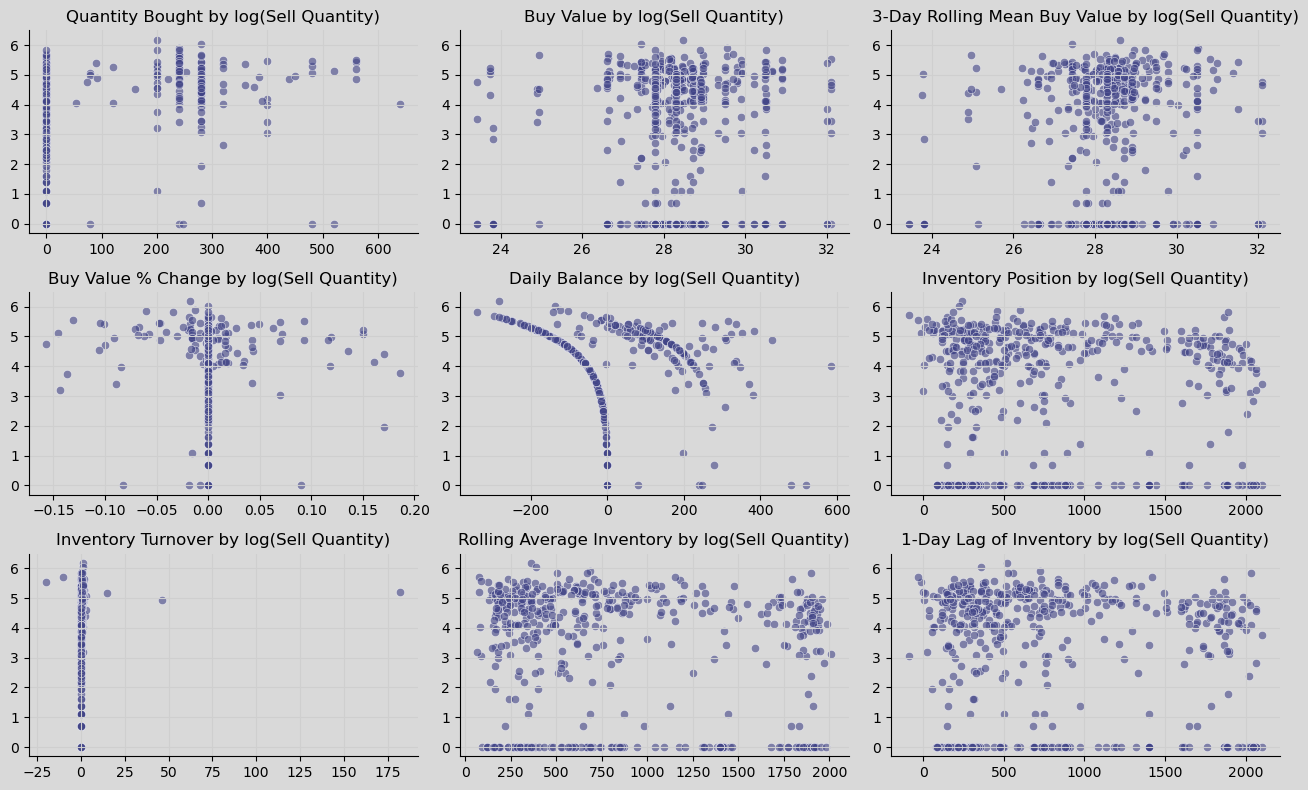

In [109]:
fig, axs = plt.subplots(3, 3, figsize = (13, 8))
fig.patch.set_facecolor("0.85")

c = 0
for i in range(3):
    for j in range(3):
        axs[i,j].grid(visible = True, color = '0.81')
        sns.scatterplot(data = df, x = cols[c], y = 'sell_quantity_log', alpha = 0.6, ax = axs[i,j], color = corViridis[1])
        axs[i,j].set_title(cols_desc[c] + ' by log(Sell Quantity)')
        axs[i,j].set_ylabel("")
        axs[i,j].set_xlabel("")
        axs[i,j].spines.right.set_visible(False)
        axs[i,j].spines.top.set_visible(False)
        axs[i,j].set_facecolor("0.85")
        c += 1

plt.tight_layout()
plt.savefig("../visuals/16.BuyQuantityAndDerivedFeaturesByLogSellQuantity.svg")
plt.show()
plt.close()

We analyzed the relationship between the following features and the target variable:
- `buy_quantity`: shows a weak but visible relationship with the target. There seems to be some influence on sales when purchases are made, though not strongly. Worth validating with feature importance;
- `buy_value`, `rolling_mean_buy_value`, and `buy_value_pct_change`: these features show very limited price variation, since most values cluster around 28.00 BRL. This lack of variation can prevent the model from capturing meaningful patterns. Since the plots are nearly identical, it suggests redundancy and low predictive value;
- `daily_balance`: displays a clear curve. When the value is negative (i.e., sales > purchases), sales tend to be higher. Which makes sense in cases of stock reduction or high demand. This feature may help the model identify stock-driven demand behavior;
- `inventory`, `inventory_lag_1`, and `avg_inventory_rolling`: all plots show similar dispersion. Sales tend to be higher when stock levels are within the 250–500 unit range, confirming that product availability directly impacts demand. These features are likely collinear, and the model may prioritize just one;
- `inventory_turnover`: this feature measures the efficiency of sales relative to stock levels. However, it shows noisy behavior in extreme values likely due to division by small inventory. It may confuse the model. Importance analysis is required to decide whether to keep it.

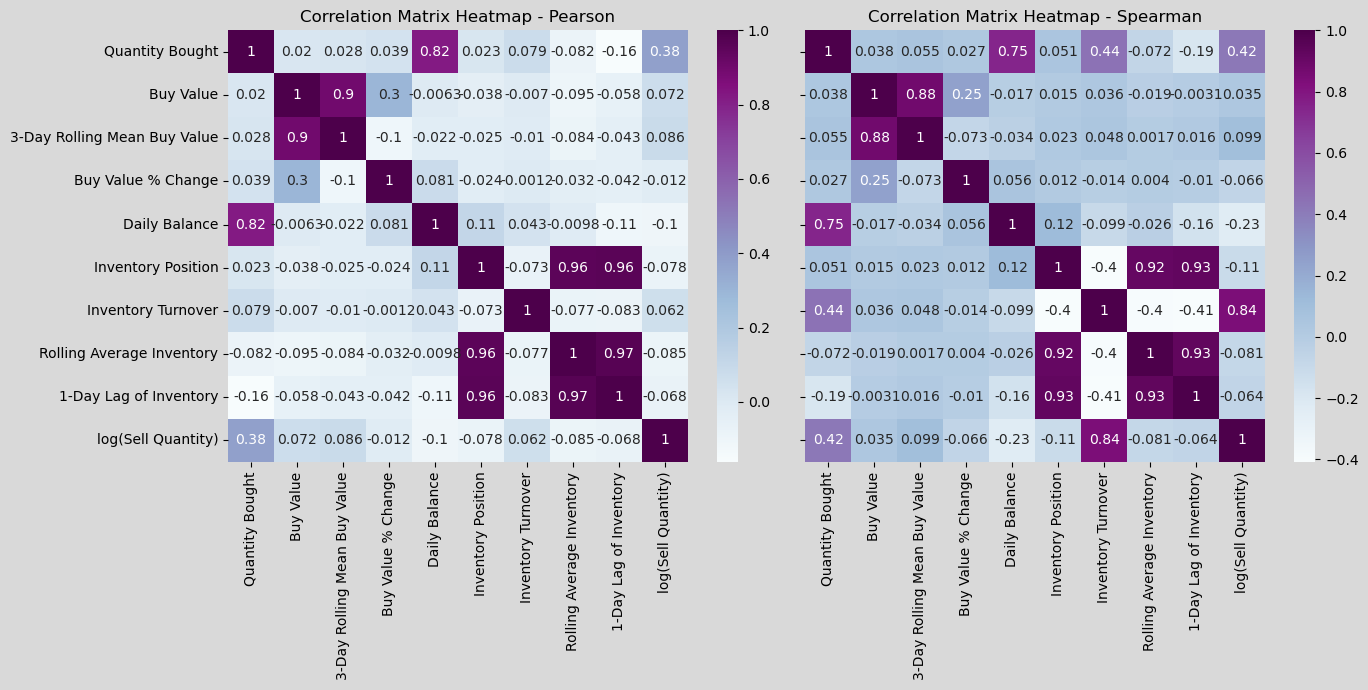

In [112]:
corr_df = df[cols + ['sell_quantity_log']].copy()
corr_df.columns = cols_desc + ['log(Sell Quantity)']

fig, axs = plt.subplots(1, 2, sharey = True, figsize = (14, 7))
fig.patch.set_facecolor("0.85")

sns.heatmap(corr_df.corr(), annot = True, cmap = 'BuPu', ax = axs[0])
axs[0].set_title("Correlation Matrix Heatmap - Pearson")

sns.heatmap(corr_df.corr(method = 'spearman'), annot = True, cmap = 'BuPu', ax = axs[1])
axs[1].set_title("Correlation Matrix Heatmap - Spearman")

plt.tight_layout()
plt.savefig("../visuals/17.BuyQuantityAndDerivedFeaturesCorrHeatmap.svg")
plt.show()
plt.close()

Key Findings and Critical Review:
- `buy_quantity`: shows very high correlation with the target variable, as well as with `daily_balance`. Since `buy_quantity` is a primary driver of supply, and `daily_balance` is a derivative of it, we will retain `buy_quantity` and remove the redundant variable.

- **`buy_value`, `rolling_mean_buy_value`, and `buy_value_pct_change`**  
  These features are highly correlated with each other, confirming redundancy. All three also show weak correlation with the target, likely due to the minimal variation in purchase prices. We will assess their predictive value using feature importance metrics before deciding whether to drop them entirely.

- **`daily_balance`**  
  Despite initially showing an interesting shape in the scatterplot, it has very low correlation with the target and is strongly collinear with `buy_quantity`. We will exclude this feature.  
  ⚠️ _Note: This feature may still carry a nonlinear signal (e.g., demand surges during stockouts). SHAP values will be reviewed to confirm irrelevance._

- **`inventory`, `inventory_lag_1`, and `avg_inventory_rolling`**  
  These three features are highly collinear and all have weak correlation with the target. We will rely on model-based importance to identify which of them, if any, adds meaningful predictive value.

- **`inventory_turnover`**  
  Surprisingly, this feature showed high Spearman correlation with the target. While it appears promising, we will validate its behavior using SHAP and permutation importance, as the metric may be skewed by extreme values in low-inventory situations. Outlier influence will be checked before confirming retention.

#### Next Step:

We will evaluate these features using:
- XGBoost feature importance
- SHAP values
- Permutation importance

This will help confirm which variables are worth keeping in the final model.